In [1]:
import os
from datetime import datetime
from datetime import timedelta
import urllib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import pandas as pd
from tqdm import tqdm
import re

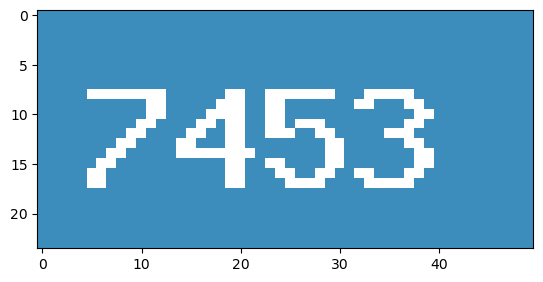

<Response [200]>
http://www.watchyourpower.org/reports.php?
Previous scraping log found:
Last read: 07/02/2025

Alipur_Cachar+Cachar+Assam
station found
Station 887 already up to date
Ameerpeth-Hyderabad+Hyderabad+Andhra_Pradesh_Telangana
station found
Station 171 already up to date
Amrit_Nagar_Hazaribagh+Hazaribagh+Jharkhand
station found
Station 905 already up to date
Aundh-Pune+Pune+Maharashtra
station found
Station 130 already up to date
Banjara_hills_Hyderabad+Hyderabad+Telangana
station found
Station 673 already up to date
Besant_Nagar_Chennai+Kancheepuram+Tamil_Nadu
station found
Station 849 already up to date
Bhopoli-Palghar+Palghar+Maharashtra
station found
Station 464 already up to date
Bhurkunda_Ramgarh+Bhurkunda+Jharkhand
station found
Station 890 already up to date
Bilasipara_Dhubri+Dhubri+Assam
station found
Station 864 already up to date
Borbheta_Jorhat+Jorhat+Assam
station found
Station 886 already up to date
Capital_Electrical_Subdivision_Guwahati+Kamrup_Metro+Assam
st

In [3]:
def date2query(date):
    return urllib.parse.quote(date.strftime('%d/%m/%Y'), safe='')


# Robust request function that automatically retries
def retry_request(url, session, total=4, status_forcelist=[429, 500, 502, 503, 504], **kwargs):
    # Make number of requests required
    for _ in range(total):
        try:
            response = session.get(url, **kwargs)
            if response.status_code in status_forcelist:
                # Retry request 
                continue

            return response
        except requests.exceptions.ConnectionError:
            pass
    return None


session = requests.Session()
LOGIN_URL = 'http://www.watchyourpower.org/admin/'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36'
}

# Retrieve and display login captcha
page_text = retry_request(url=LOGIN_URL, session=session, headers=HEADERS)
img_url = 'http://www.watchyourpower.org/captcha.php'
img_data = retry_request(url=img_url, session=session, headers=HEADERS).content

with open('./captcha.jpg','wb') as fp:
    fp.write(img_data)

image = mpimg.imread("./captcha.jpg")
plt.imshow(image)
plt.show()
img_code = input('Enter captcha：')

USERNAME ='junrentschler'
PASSWORD ='jun@2018'
data = {'username': USERNAME,
        'password': PASSWORD,
        'code': img_code,
        'login': 'Login'}

# Sign into watch your power session
index = session.post(url=LOGIN_URL, headers=HEADERS, data=data)
print(index)

DETAIL_URL = 'http://www.watchyourpower.org/reports.php?category_id=3&location_id=119&from_date=13%2F01%2F2017&to_date=13%2F02%2F2017'
detail_text = retry_request(url=DETAIL_URL, session=session, headers=HEADERS).text

if detail_text.find('Welcome') == -1:
    exit()

# Output directory, india_esmi by default, change as needed
INDIA_SCRAPE_DIR = f'india_esmi'

# Pull up the dashboard page and retrieve all available monitoring station ids
# Because nothing is specified, the rightmost dropdown "Location" will have all the monitoring stations available
API_URL = f'http://www.watchyourpower.org/reports.php?'
print(API_URL)

res = retry_request(url=API_URL, session=session, headers=HEADERS)
if res.ok:
    text = res.text

    # Isolate the section of the html that contains the monitoring station dropdown
    text_list = text.split('<option value="">-- Select  --</option>')[1].split('</select>')[0]
    text_list = re.split('<option class="" | >', text_list)
    stationIDs = [elem[6:].replace('\"', '').replace(' ', '+') for elem in text_list if elem.startswith("value=")]

    # If the output directory already exists, check the log to see the ids and last scraped dates for all of the stations
    last_scraped = {}
    today_string = datetime.now().strftime('%m/%d/%Y')

    # Ensure the output directory exists for the latest run of the scraper and retrieve last scraped dates
    # to avoid repeat work
    if os.path.exists(INDIA_SCRAPE_DIR):
        if os.path.exists(f'{INDIA_SCRAPE_DIR}/log.txt'):
            with open(f'{INDIA_SCRAPE_DIR}/log.txt', 'r') as f:
                print('Previous scraping log found:')
                print(f'Last read: {f.readline().split(":")[1]}')

                for line in f:
                    title, id, date = line.strip().split(',')
                    last_scraped[id] = (datetime.strptime(date, '%m/%d/%Y'), title)
    else:
        os.makedirs(INDIA_SCRAPE_DIR)

    try:
        for id in stationIDs:
            # Query just the location with no dates to pull up the error text which informs us of the available data dates
            url = f'http://www.watchyourpower.org/reports.php?location_id={id}'
            res = retry_request(url=url, session=session, headers=HEADERS)

            range_start = None
            range_end = None
            title = ""

            if res:
                empty_chart_match = re.search(r'<span class="empty_chart">([\S\s]*?)<\/span>', res.text)
                if empty_chart_match:
                    empty_chart_content = empty_chart_match.group(1)
                    range_start = datetime.strptime(empty_chart_content.split('From ')[1].split(' To ')[0].strip(), '%d/%m/%Y')
                    range_end = datetime.strptime(empty_chart_content.split(' To ')[1].strip(), '%d/%m/%Y')
                    
                    # Ignore data before 2015 due to poor data quality before official program launch
                    if range_start < datetime(year=2015, month=1, day=1):
                        range_start = datetime(year=2015, month=1, day=1)

                title_match = re.search(r'<h4>[\s]*?Location - (.*?), District - (.*?), State - (.*?) \..*?<\/h4>', res.text)
                location = title_match.group(1).strip()
                district = title_match.group(2).strip()
                state = title_match.group(3).strip()
                title = re.sub(r'[\s]*-[\s]*', '-', f'{location}+{district}+{state}'.replace('/', '_')).replace(' ', '_')
                print(title)
            else:
                print(f'Failed to retrieve data for station {id}')
                continue

            # If the station has already been scraped, check the last scraped date and start from there
            if id in last_scraped:
                print('station found')
                last_date = last_scraped[id][0]
                if last_date >= range_start:
                    range_start = last_date + timedelta(days=1)
                
                if range_end < range_start: # If the last scraped date is after the last available date, skip this station
                    print(f'Station {id} already up to date')
                    continue

            query_start = range_start
            query_end = query_start + timedelta(days=31)

            # Loop through the available data period in 31 day intervals
            dates = []
            voltages = []
            with tqdm(total=(range_end - range_start).days) as pbar:
                while query_end <= range_end and query_start < query_end:
                    url = f'http://www.watchyourpower.org/reports.php?location_id={id}&from_date={date2query(query_start)}&to_date={date2query(query_end)}'
                    res = retry_request(url=url, session=session, headers=HEADERS)

                    if res:
                        text = res.text
                        pbar.set_description(f'Scraping {query_start.strftime("%m/%d/%Y")} to {query_end.strftime("%m/%d/%Y")} for station {id}')

                        # Separate out all of the line chart data points into their "date" : date, "voltage" : voltage pairs, with the brackets removed
                        test_split = text.split('linechartData = [{')
                        if len(test_split) < 2:
                            pbar.set_description(f'No data found for station {id} between {query_start.strftime("%m/%d/%Y")} and {query_end.strftime("%m/%d/%Y")}')
                            # If the data is not empty, which would present the empty_chart span, save the html for manual inspection
                            if not re.search(r'<span class="empty_chart">([\S\s]*?)<\/span>', res.text):
                                with open(f'{INDIA_SCRAPE_DIR}/error_{id}_{query_start.strftime("%m-%d-%Y")}.html', 'w') as f:
                                    f.write(text)
                        else:
                            datapoints = test_split[1].split('];')[0].split('},{')
                            for point in datapoints:
                                date = datetime.strptime(point.split('"date":"')[1].split('","')[0], '%a %b %d %Y %H:%M:%S')
                                voltage = int(point.split('"voltage":"')[1].split('"')[0])

                                dates.append(date)
                                voltages.append(voltage)

                    pbar.update((query_end - query_start).days + 1)
                    
                    query_start = query_end + timedelta(days=1)
                    query_end = query_start + timedelta(days=31)

                    if query_end > range_end:
                        query_end = range_end

            # Update last scraped
            last_scraped[id] = (range_end, title)

            print(f'Total entries: {len(dates)}')
            df = pd.DataFrame({'time': dates, 'voltage': voltages})
            if id in last_scraped: # Update old file if it exists
                df_old = pd.read_csv(f'{INDIA_SCRAPE_DIR}/{id}+{title}.csv')
                df = pd.concat([df_old, df], ignore_index=True)
            
            df.to_csv(f'{INDIA_SCRAPE_DIR}/{id}+{title}.csv', index=False)
    
    # Update the log file
    finally:
        with open(f'{INDIA_SCRAPE_DIR}/log.txt', 'w') as f:
            f.write(f'Last Scraped:{today_string}\n')
            for id, info in last_scraped.items():
                date = info[0]
                title = info[1]
                f.write(f'{title},{id},{date.strftime("%m/%d/%Y")}\n')